# Synthetic Sonic Log Generation

In [1]:
# import libraries
# For Suppressing Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# general
import pandas as pd
import numpy as np
# Plotting Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn libararies
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
# ML Model
import xgboost as xgb
# For Automatic EDA
#from pandas_profiling import ProfileReport

In [2]:
! mkdir data
! wget -P data https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Data3_1_2020.zip?raw=true
! unzip data/Data3_1_2020.zip?raw=true -d data
! rm data/Data3_1_2020.zip?raw=true

--2020-05-08 03:33:10--  https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Data3_1_2020.zip?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip [following]
--2020-05-08 03:33:10--  https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pddasig/Machine-Learning-Competition-2020/master/Data3_1_2020.zip [following]
--2020-05-08 03:33:10--  https://raw.githubusercontent.com/pddasig/Machine-Learning-Competition-2020/master/Data3_1_2020.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.

In [3]:
! ls data

sample_submission.csv  test.csv  train.csv


In [4]:
# We also need to download the blind test dataset from 20% of the hidden dataset, which we received over the email and then uploaded to github
! wget https://raw.githubusercontent.com/choukha/pddata/master/real_result_20perc.csv

--2020-05-08 03:37:09--  https://raw.githubusercontent.com/choukha/pddata/master/real_result_20perc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148252 (145K) [text/plain]
Saving to: ‘real_result_20perc.csv’

real_result_20perc. 100%[===================>] 144.78K  --.-KB/s    in 0.03s   

2020-05-08 03:37:10 (4.19 MB/s) - ‘real_result_20perc.csv’ saved [148252/148252]



In [2]:
# Training Data
df = pd.read_csv('train.csv')

In [3]:
# Small Test Dataset ( 20% )
dt = pd.read_csv('real_result_20perc.csv')

In [4]:
# TEST FILE
test = pd.read_csv("test.csv")

In [5]:
print(df.shape,dt.shape,test.shape)

(30143, 9) (2217, 9) (11088, 7)


In [6]:
df.columns

Index(['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS'], dtype='object')

In [7]:
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [8]:
test.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


Test Data seems quite different from the Train Data. We also checked for the covariate shift between these two datasets and found that both the datasets are different due to different distributions of CAL, PE and others. Information from covariate shift can be utilized to select the features or giving weights to training instances.

In [9]:
# For convenience, let's copy the Raw Training data into another dataframe to further work and modify
df1 = df.copy()

In [10]:
# Replace value -999 ( missing value indicators ) as NA
df1.replace(['-999', -999], np.nan, inplace=True)

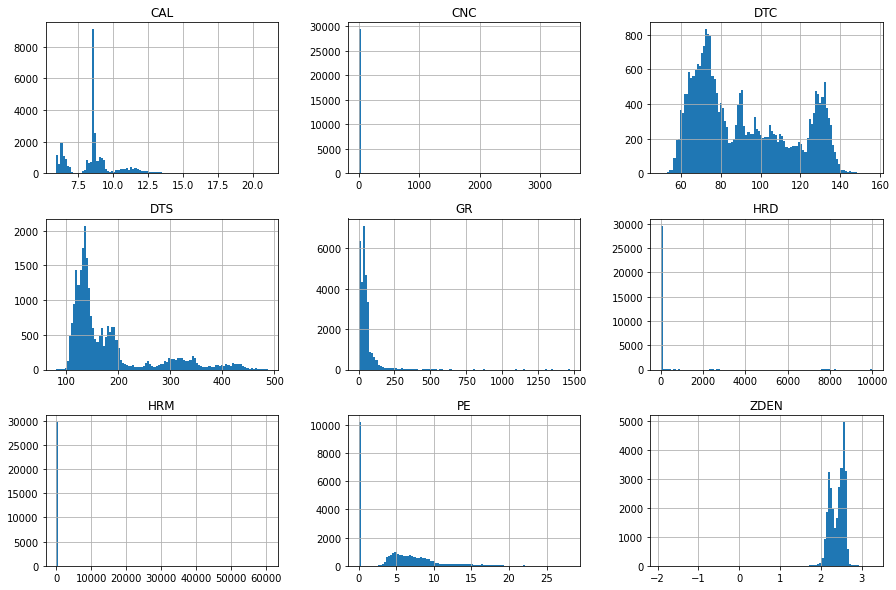

In [0]:
histdf = df1.hist(bins=100,figsize=(15,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37fa2d90b8>,
      dtype=object)

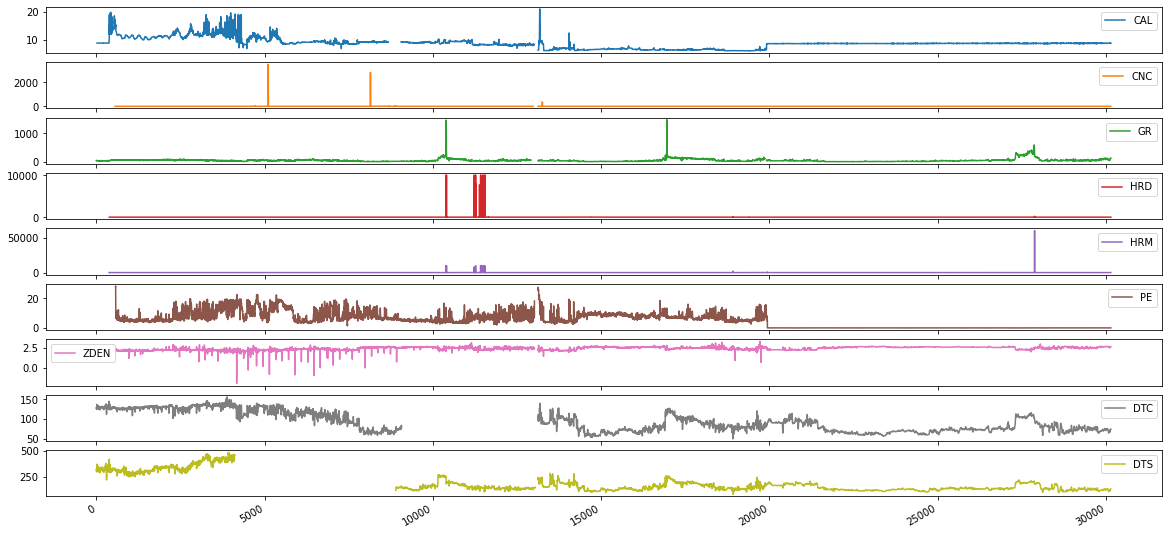

In [0]:
df1.plot(subplots=True,figsize=(20,10))

###  Nullify the Negative Values</a>

In [11]:
df1['ZDEN'][df1['ZDEN']<0] = np.nan
df1['GR'][df1['GR']<0] = np.nan
df1['CNC'][df1['CNC']<0] = np.nan
df1['PE'][df1['PE']<0] = np.nan

###  Nullify the Extreme Values or Outliers</a>
Outlier limits and ranges are identified based on the stats from Train and Test data. Instead of dropping the rows with such values, we replace them with NaNs

In [12]:
# GR
df1['GR'][(df1['GR']>250)] = np.nan
# CNC
df1['CNC'][df1['CNC']>0.7] = np.nan
# HRM & HRD
df1['HRD'][df1['HRD']>200] = np.nan
df1['HRM'][df1['HRM']>200] = np.nan

###  Log Transformation on skewed variables </a>
HRD and HRM variables are quite skewed, hence we need to transform them.

In [13]:
df1['HRM'] = df1['HRM'].apply(lambda x:np.log(x))
df1['HRD'] = df1['HRD'].apply(lambda x:np.log(x))

In [14]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,29633.000000,29195.000000,29513.000000,29683.000000,29687.000000,29455.000000,29454.000000,26089.000000,25278.000000
mean,8.654281,0.245114,44.140058,0.475938,0.490181,5.174812,2.394661,91.814381,180.655730
std,1.749145,0.152072,36.486081,0.977667,0.988046,4.780959,0.189292,24.337910,81.141960
min,5.930400,0.004100,0.000000,-2.916921,-2.787093,0.000000,0.003500,49.970500,80.580400
25%,8.135600,0.126600,17.682600,-0.303066,-0.309723,0.054200,2.234900,71.357000,129.446625
50%,8.625000,0.197300,36.719400,0.503861,0.505914,5.043800,2.439700,85.237600,144.593050
75%,9.063000,0.337900,57.633200,1.153542,1.191723,7.950150,2.553100,112.112600,191.475125
max,21.064200,0.699600,249.904800,5.292286,5.287507,28.106400,3.259700,155.980300,487.438400


###  Correlations</a>

In [15]:
df1.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,0.582005,0.040421,-0.199495,-0.164176,0.163877,-0.368183,0.585637,0.681271
CNC,0.582005,1.000000,0.486927,-0.526469,-0.531618,0.437687,-0.698973,0.943968,0.898753
GR,0.040421,0.486927,1.000000,-0.104434,-0.111190,0.031718,-0.178068,0.427692,0.308994
HRD,-0.199495,-0.526469,-0.104434,1.000000,0.981400,-0.245251,0.622416,-0.608752,-0.436526
HRM,-0.164176,-0.531618,-0.111190,0.981400,1.000000,-0.279317,0.622436,-0.605481,-0.435709
PE,0.163877,0.437687,0.031718,-0.245251,-0.279317,1.000000,-0.340607,0.477524,0.440266
ZDEN,-0.368183,-0.698973,-0.178068,0.622416,0.622436,-0.340607,1.000000,-0.756792,-0.670186
DTC,0.585637,0.943968,0.427692,-0.608752,-0.605481,0.477524,-0.756792,1.000000,0.941639
DTS,0.681271,0.898753,0.308994,-0.436526,-0.435709,0.440266,-0.670186,0.941639,1.000000


In [16]:
test.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
CAL,1.000000,-0.290943,0.024399,0.037764,0.050929,0.446757,0.438947
CNC,-0.290943,1.000000,0.575440,-0.247362,0.016520,-0.563464,-0.710657
GR,0.024399,0.575440,1.000000,-0.124756,0.154772,-0.121305,-0.129897
HRD,0.037764,-0.247362,-0.124756,1.000000,0.415450,-0.002108,0.077118
HRM,0.050929,0.016520,0.154772,0.415450,1.000000,0.046397,0.028714
PE,0.446757,-0.563464,-0.121305,-0.002108,0.046397,1.000000,0.870180
ZDEN,0.438947,-0.710657,-0.129897,0.077118,0.028714,0.870180,1.000000


In [17]:
dt.corr()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
CAL,1.000000,-0.272537,0.045407,0.034635,0.060653,0.459406,0.440301,-0.320136,-0.410835
CNC,-0.272537,1.000000,0.548729,-0.209147,-0.015163,-0.532309,-0.680442,0.932308,0.839232
GR,0.045407,0.548729,1.000000,-0.102104,0.038432,-0.026737,-0.057722,0.466689,0.348867
HRD,0.034635,-0.209147,-0.102104,1.000000,0.528032,-0.028078,0.047874,-0.161745,-0.209074
HRM,0.060653,-0.015163,0.038432,0.528032,1.000000,0.051307,0.036016,-0.010130,-0.026211
PE,0.459406,-0.532309,-0.026737,-0.028078,0.051307,1.000000,0.873218,-0.684861,-0.499729
ZDEN,0.440301,-0.680442,-0.057722,0.047874,0.036016,0.873218,1.000000,-0.786119,-0.644818
DTC,-0.320136,0.932308,0.466689,-0.161745,-0.010130,-0.684861,-0.786119,1.000000,0.814091
DTS,-0.410835,0.839232,0.348867,-0.209074,-0.026211,-0.499729,-0.644818,0.814091,1.000000


###  Predictive Power Score (PPS)</a>
The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

<AxesSubplot:xlabel='x', ylabel='y'>

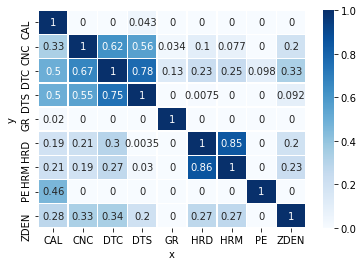

In [19]:
! pip install ppscore
import ppscore as pps
matrix_df = pps.matrix(df1).pivot(columns='x', index='y',  values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## Build Machine Learning Models</a>

### 4.1 Split the training data into Train & Test</a>


In [20]:
# Create separate datasets for DTC and DTS
df_dtc = df1.dropna(subset=['DTC'])
df_dts = df1.dropna(subset=['DTS'])

**X**

In [21]:
df_dtc_x = df_dtc.drop(columns=['DTC','DTS'])
df_dts_x = df_dts.drop(columns=['DTC','DTS'])

**Y**

In [22]:
y_dtc = df_dtc['DTC']
y_dts = df_dts['DTS']

In [23]:
X_train_dtc, X_test_dtc, y_train_dtc, y_test_dtc = train_test_split(df_dtc_x,y_dtc, test_size=0.30, random_state=42, shuffle = True)

In [24]:
X_train_dts, X_test_dts, y_train_dts, y_test_dts = train_test_split(df_dts_x,y_dts, test_size=0.30, random_state=42, shuffle = True)

#### 4.2.1 Model for DTC </a>

In [25]:
xgb_model_dtc = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.18, n_estimators=145, min_child_weight = 6, gamma = 0.3)

In [26]:
xgb_model_dtc.fit(X_train_dtc, y_train_dtc)
y_pred_test_dtc = xgb_model_dtc.predict(X_test_dtc)
y_pred_train_dtc = xgb_model_dtc.predict(X_train_dtc)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dtc,y_pred_train_dtc))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dtc,y_pred_test_dtc))))
print("R2_train:     " + str(r2_score(y_train_dtc,y_pred_train_dtc)))
print("R2_test:     " + str(r2_score(y_test_dtc,y_pred_test_dtc)))

RMSE_train:     4.482276596676145
RMSE_test:     4.946417151942143
R2_train:     0.9660135316729921
R2_test:     0.9588746577098913


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

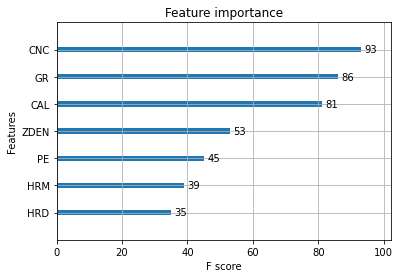

In [27]:
xgb.plot_importance(xgb_model_dtc)

####  Model for DTS </a>

In [28]:
xgb_model_dts = xgb.XGBRegressor(random_state=42, max_depth=7,learning_rate=0.19, n_estimators=135, min_child_weight = 6, gamma = 0.7)

In [29]:
xgb_model_dts.fit(X_train_dts, y_train_dts)
y_pred_test_dts = xgb_model_dts.predict(X_test_dts)
y_pred_train_dts = xgb_model_dts.predict(X_train_dts)
print("RMSE_train:     " + str(np.sqrt(mean_squared_error(y_train_dts,y_pred_train_dts))))
print("RMSE_test:     " + str(np.sqrt(mean_squared_error(y_test_dts,y_pred_test_dts))))
print("R2_train:     " + str(r2_score(y_train_dts,y_pred_train_dts)))
print("R2_test:     " + str(r2_score(y_test_dts,y_pred_test_dts)))

RMSE_train:     5.311352991488709
RMSE_test:     9.355877762016958
R2_train:     0.9956638631907018
R2_test:     0.9870600144025744


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

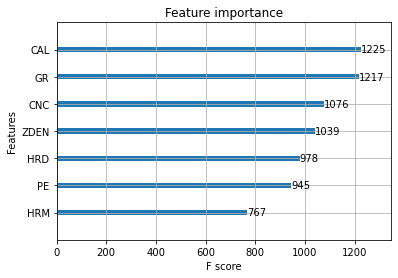

In [30]:
xgb.plot_importance(xgb_model_dts)

##  Model Predictions and Performance on Small Test Data</a>

#### Helper Function to plot the Results

In [54]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Combined r2 score is:', '{:.5f}'.format(np.sqrt(r2_score(y_real, y_predict))))
    dtc_real = y_real[:, 0]
    dtc_pred = y_predict[:, 0]
    dts_real = y_real[:, 1]
    dts_pred = y_predict[:, 1]
    print('DTC:', '{:.5f}'.format(np.sqrt(r2_score(dtc_real, dtc_pred))))
    print('DTS:', '{:.5f}'.format(np.sqrt(r2_score(dts_real, dts_pred))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

### Data preparation for using Model
Apply the filters and transformation, which were applied on Training data.

In [32]:
# Replace value -999 ( missing value indicators ) as NA
dt.replace(['-999', -999], np.nan, inplace=True)
# Nullify the Negative Values
dt['CNC'][dt['CNC']<0] = np.nan
dt['GR'][dt['GR']<0] = np.nan
dt['PE'][dt['PE']<0] = np.nan
dt['ZDEN'][dt['ZDEN']<0] = np.nan
# Nullify the Outliers
dt['CNC'][dt['CNC']>0.7] = np.nan
dt['GR'][(dt['GR']>250)] = np.nan
dt['HRD'][dt['HRD']>200] = np.nan
dt['HRM'][dt['HRM']>200] = np.nan
# Log Transformation
dt['HRD'] = np.log(dt['HRD'])
dt['HRM'] = np.log(dt['HRM'])

In [33]:
dt_x = dt.drop(columns=['DTC','DTS'])

### Predict and Check the performance

In [34]:
# Separate the Actual/True Values of DTC and DTS
reals = np.array(dt.loc[:,['DTC','DTS']])

In [35]:
# Predict DTC and DTS using the trained models
dtc_predict = xgb_model_dtc.predict(dt_x)
dts_predict = xgb_model_dts.predict(dt_x)
preds_df = pd.DataFrame({'DTC':dtc_predict,'DTS':dts_predict})
preds = np.array(preds_df)

Combined r2 score is: 0.91146
DTC: 0.96064
DTS: 0.85946


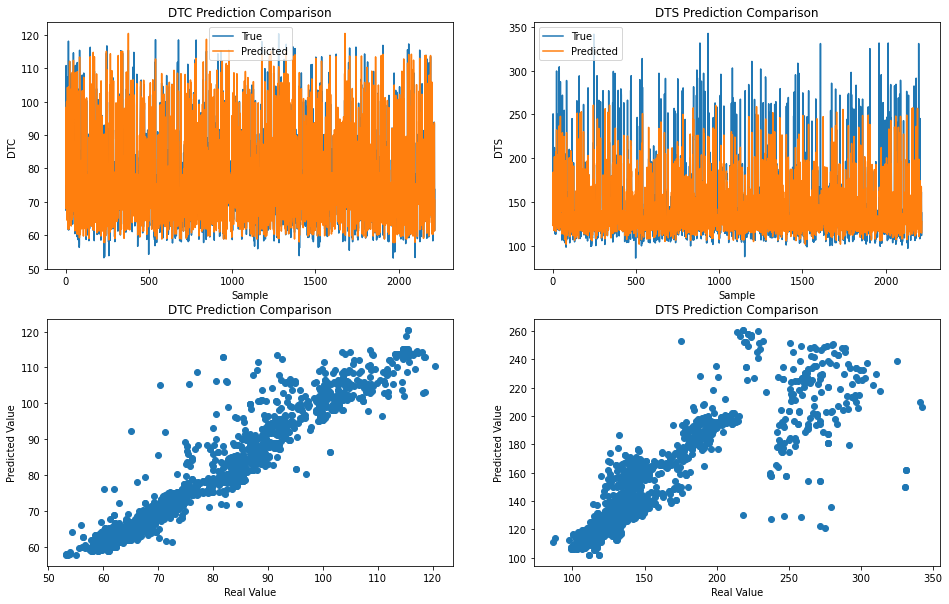

In [55]:
# Plot the Results and Print the Metrics
result_plot(preds,reals)